In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_path = os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train")
valid_path = os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "valid")
test_path = os.path.join(path, "test", "test")

In [ ]:
print("Train Path Exists:", os.path.exists(train_path))
print("Valid Path Exists:", os.path.exists(valid_path))
print("Test Path Exists:", os.path.exists(test_path))

Train Path Exists: True
Valid Path Exists: True
Test Path Exists: True


In [ ]:
# Parameters
img_width, img_height = 224, 224
batch_size = 32

In [ ]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = test_val_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Load test data manually (as it's not organized into subfolders)
test_images = []
test_image_paths = [os.path.join(test_path, img) for img in os.listdir(test_path)
                    if img.lower().endswith(('png', 'jpg', 'jpeg'))]

for img_path in test_image_paths:
    img = load_img(img_path, target_size=(img_width, img_height))
    img = img_to_array(img) / 255.0
    test_images.append(img)

test_images = np.array(test_images)
print("Loaded test images:", test_images.shape)

Loaded test images: (33, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Get number of classes from train generator
num_classes = train_generator.num_classes

# Build the model with MobileNetV2 base
base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1337s 603ms/step - accuracy: 0.3477 - loss: 2.5330 - val_accuracy: 0.7879 - val_loss: 0.8261
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 966s 435ms/step - accuracy: 0.7723 - loss: 0.8277 - val_accuracy: 0.8429 - val_loss: 0.5617
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 964s 427ms/step - accuracy: 0.8281 - loss: 0.5983 - val_accuracy: 0.8722 - val_loss: 0.4553
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 930s 423ms/step - accuracy: 0.8513 - loss: 0.5044 - val_accuracy: 0.8832 - val_loss: 0.4011
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 943s 429ms/step - accuracy: 0.8650 - loss: 0.4488 - val_accuracy: 0.8914 - val_loss: 0.3661
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 948s 431ms/step - accuracy: 0.8751 - loss: 0.4144 - val_accuracy: 0.9008 - val_loss: 0.3369
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 942s 429ms/step - accuracy: 0.8784 - loss: 0.3921 - val_accuracy: 0.9037 - val_loss: 0.3245
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 934s 425ms/step - a

In [ ]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_acc:.4f}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 48s 86ms/step - accuracy: 0.9136 - loss: 0.2874
Validation Accuracy: 0.9140


In [ ]:
# Predictions on test data
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


In [ ]:
# Class labels mapping
class_indices = train_generator.class_indices
labels_map = dict((v, k) for k, v in class_indices.items())
predicted_labels = [labels_map[i] for i in pred_classes]

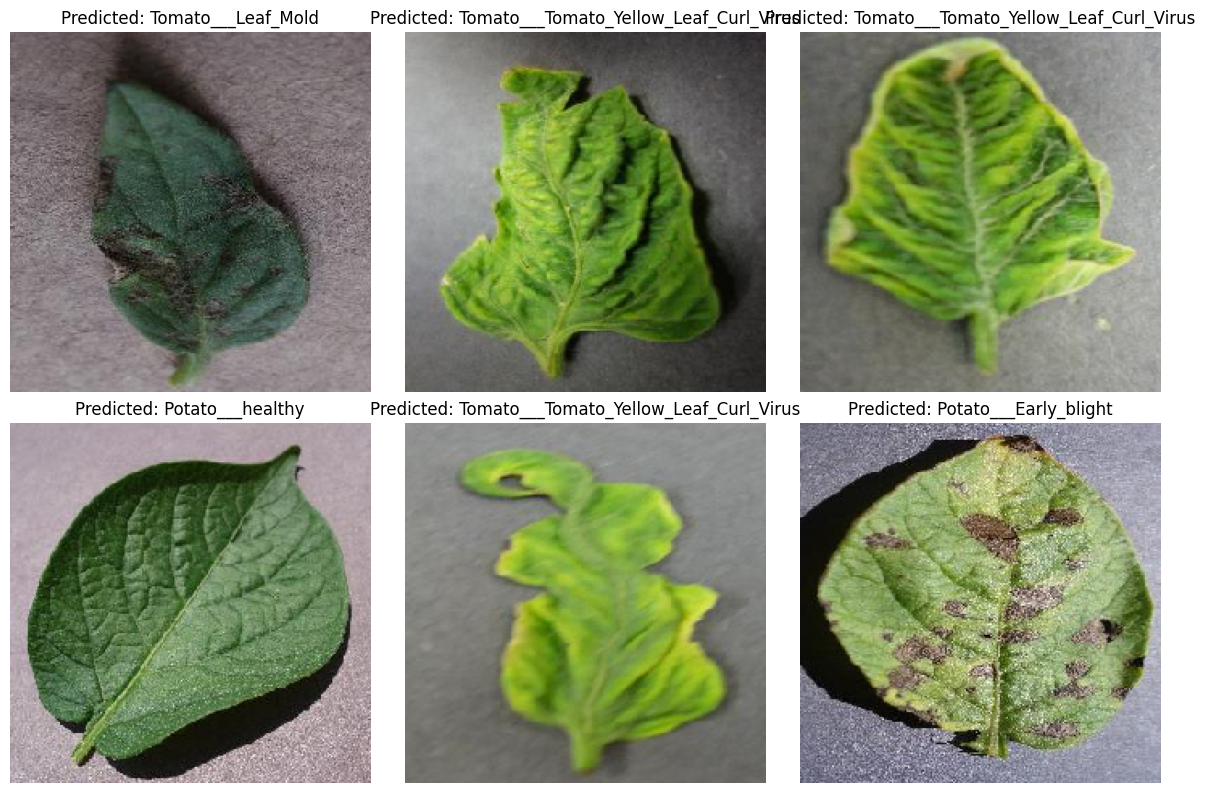

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()